#Step 0: Problem Statement

Aim of the project is to localize and classify surface defects on a steel sheet.

Data source: https://www.kaggle.com/c/severstal-steel-defect-detection

#Step 1: Import packages

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
import os
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#navigate to My Drive directory to store the dataset
%cd /content/drive/My Drive     

/content/drive/My Drive


#Step 2: Uploading the data

It would take around 15 to 25 minutes to upload the dataset using the following command . Alternatively, you can upload the data directly tp your dtive using google drive upload.

In [0]:
files.upload()

In [0]:
!unzip severstal-steel-defect-detection.zip

In [0]:
!mkdir Steel_Defect_Detection
!mv test_images Steel_Defect_Detection/test_images
!mv train_images Steel_Defect_Detection/train_images
!mv train.csv Steel_Defect_Detection/train.csv
!mv sample_submission.csv Steel_Defect_Detection/sample_submission.csv

#Step 3: Import the data

In [0]:
train_df = pd.read_csv('Steel_Defect_Detection/train.csv')
test_df = pd.read_csv('Steel_Defect_Detection/sample_submission.csv')

In [0]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [0]:
test_df.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


# Step 3: Data Visualization

In [0]:
train_df['mask'] = train_df['ClassId'].map(lambda x: 1)

In [0]:
defect_type = train_df.groupby(['ImageId'])['mask'].sum()
defect_type.value_counts()

1    6239
2     425
3       2
Name: mask, dtype: int64

Text(0.5, 1.0, 'Number of defects in image')

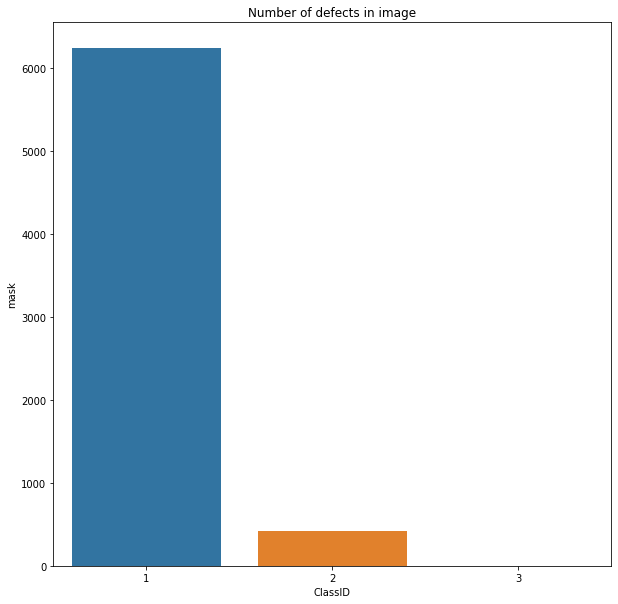

In [0]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [0]:
defect_type_count = train_df.ClassId.value_counts()
defect_type_count

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

Text(0.5, 1.0, 'Number of images per class')

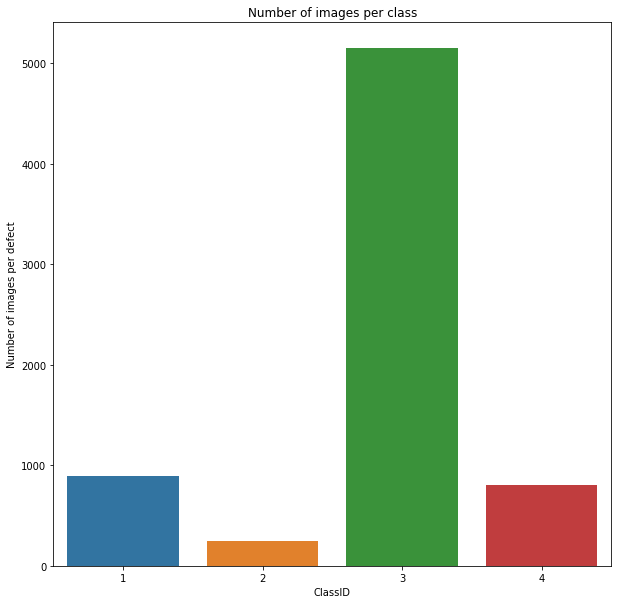

In [0]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type_count.index, y = defect_type_count )
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')

In [0]:
train_df.shape

(7095, 4)

In [0]:
train_dir = 'Steel_Defect_Detection/train_images/'


## Creating a new dataframe containing both defect and non-defect steel images:

Train image folder contains 12568 images and the train_df only contains 7095 entries corresponding to 6666 images. Remaining images that do not have labels have no defect.

In [0]:
no_defect = []
for i in os.listdir('Steel_Defect_Detection/train_images'):
  if i not in list(train_df.ImageId) :
    no_defect.append(i)

In [79]:
len(no_defect)

5902

In [0]:
#creating a list containing all the image_id from train_df
image_id = [i for i in train_df.ImageId]

#appending the image from no_defect list to the image_id list
for j in no_defect:
  image_id.append(j)

In [0]:
#creating a list containing label '0' for no_defect and '1' for defect
label = [1 for i in train_df.ImageId]
for j in no_defect:
  label.append(0)


In [82]:
#creating a new data frame containing all image id and their corresponding labels

df_data= pd.DataFrame({'ImageID': image_id, 'label': label})
df_data.head()

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


In [83]:
df_data.shape

(12997, 2)

In [84]:
df_data.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

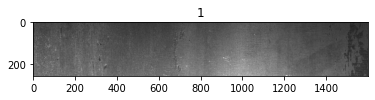

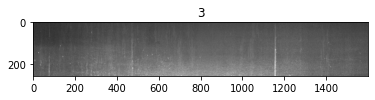

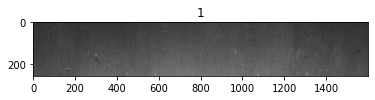

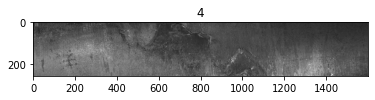

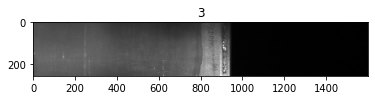

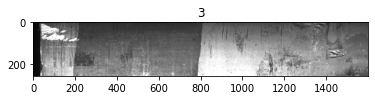

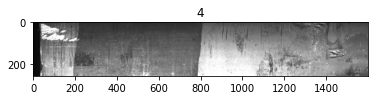

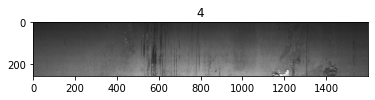

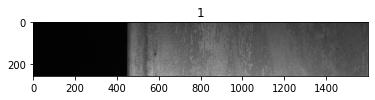

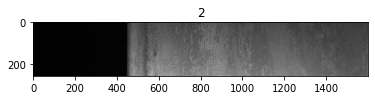

In [85]:
from google.colab.patches import cv2_imshow

for i in range(10):
  img = cv2.imread(os.path.join(train_dir,train_df.ImageId[i]))
  plt.figure()
  plt.title(train_df.ClassId[i])
  plt.imshow(img)


## Utility function

- since the data provided for segmentation is in RLE format( run-length encoded ), we will be using the following function to convert the RLE to mask. Also, inorder to check the accuracy we have to again convert the mask to RLE.

Code source for these function : https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [0]:
#function to convert rle to mask

def rle2mask(rle, height, width):
  

  #creating a one dimentional array containing 0's of length obtained by multiplying height and width of the image
  mask = np.zeros(height*width).astype(np.uint8)

  #spliting the rle based on space , try running the rle.split() on separate cell to see how the values are separated based on space
  rle = rle.split()

  #selecting every second value in the list like obtaining values corresponding to indexes 0,2,4,....
  start = rle[0::2]

  #selecting every second value in the list like obtaining values corresponding to indexes 1,3,5,....
  length = rle[1::2]

  '''
  For example rle value looks like this '4954 7 5800 20', in such a case elements belonging to even index like 4954, 5800 
  are taken as start point and the values belong to odd index likr 7,20 are the length. So we need to add length to the repective
  start pixels like 4954+7 and 5800+20, to the ending point. Now, we need to  apply mask '1' in pixles from 4954 to 4961 and 5800 to 5820.
  '''
  
  for i in range(len(start)):
    mask[int(start[i]):(int(start[i])+int(length[i]))] = 1
  
  #Now the shape of the mask is one dimention, we need to convert the mask to the same dimention of the image, initally using reshape and followed by Trasnpose
  img = mask.reshape(width, height)
  img = img.T
  return img
  

In [0]:
#Function to convert mask to rle

def mask2rle(mask):

  #We do the reverse of what we did in the above function, initially apply Transpose to the mask image and then flatten to one dimention
  pixels = mask.T.flatten()

  #Here, we add extra values at front and end , this would help in finding the correct length of pixels that have been masked
  pixels = np.concatenate([[0], pixels, [0]])

  '''
  Here, consider a array which is like [0,0,1,1,1,0], we added two values at the first and last of the array, now the array looks like
  [0,0,0,1,1,1,0,0]. After that, we check whether pixels[1:] != pixels[:-1], (i.e.)[0,0,1,1,1,0,0] != [0,0,0,1,1,1,0]. As you can see, if we
  compared these two we would get something like[False,False,True,False,False,True,False]. Then,using np.where, we will get indexes
  corresponding to True, in this case, 2 and 5
  '''
  rle = np.where(pixels[1:] != pixels[:-1])[0]

  #here we subtract values in even index in the obtained list(i.e) [2,5], from the odd index, (i.e.)5-2 = 3, Now the list would look like [2, 3]
  rle[1::2] -= rle[0::2]
  
  #finally join to rle format, in this case it would look like ('2 3')
  return ' '.join(str(x) for x in rle)
  



## Visualizing the mask

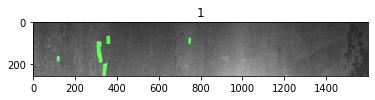

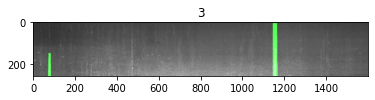

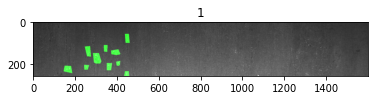

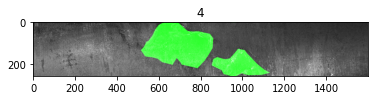

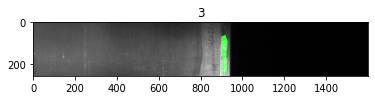

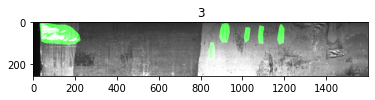

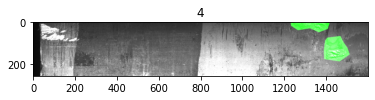

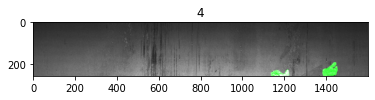

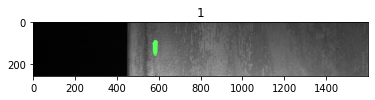

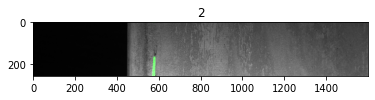

In [76]:
for i in range(10):

  #reading the images using opencv and converting to rgb format
  img = cv2.imread(os.path.join(train_dir,train_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  #getting the mask for the image from rle
  mask = rle2mask(train_df.EncodedPixels[i],img.shape[0],img.shape[1])
  '''
  Applying the mask to the image 'mask==1' and choosing the color '1' -green (since it is in RGB color space R-0, G-1, B-2),
  we have chose 255- white as the inital mask color
  '''

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(train_df.ClassId[i])
  plt.imshow(img)

Text(0.5, 1.0, 'Defect and non-defect images')

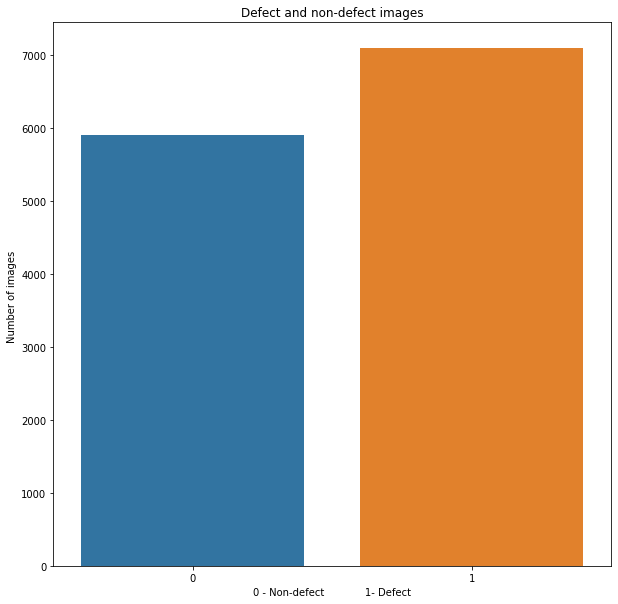

In [86]:
plt.figure(figsize=(10,10))
sns.barplot(x = df_data.label.value_counts().index, y = df_data.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

#Step 4: Creating a model to classify whether the image has defect or not:

In [0]:
#spliting the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(df_data, test_size=0.15)

In [0]:
#creating a image genrator
from keras_preprocessing.image import ImageDataGenerator

#Creating a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)


train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= train_dir,
x_col="ImageID",
y_col="label",
subset="training",
batch_size=16,
shuffle=True,
class_mode="other",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= train_dir,
x_col="ImageID",
y_col="label",
subset="validation",
batch_size=16,
shuffle=True,
class_mode="other",
target_size=(256,256))

#Creating a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= train_dir,
x_col="ImageID",
y_col=None,
batch_size=16,
shuffle=False,
class_mode=None,
target_size=(256,256))



##Pre-Trained Resnet-50 to classify wether the steel has defect or not

In [0]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [0]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers:
  layers.trainable = False

In [0]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [0]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [0]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="Steel_Defect_Detection/weights.hdf5", verbose=1, save_best_only=True)

In [0]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.7757 
Epoch 00001: val_loss improved from inf to 0.74314, saving model to Steel_Defect_Detection/weights.hdf5
586/586 [==============================] - 7361s 13s/step - loss: 0.5289 - accuracy: 0.7757 - val_loss: 0.7431 - val_accuracy: 0.4630
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8519
Epoch 00002: val_loss did not improve from 0.74314
586/586 [==============================] - 217s 370ms/step - loss: 0.3533 - accuracy: 0.8519 - val_loss: 1.7192 - val_accuracy: 0.5370
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.8812
Epoch 00003: val_loss did not improve from 0.74314
586/586 [==============================] - 213s 364ms/step - loss: 0.2887 - accuracy: 0.8812 - val_loss: 1.2313 - val_accuracy: 0.7191
Epoch 4/40
586/586 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.8972
Epoch

In [0]:
#saving the model architecture to json file for future use

model_json = model.to_json()
with open("Steel_Defect_Detection/resnet-50-steel.json","w") as json_file:
  json_file.write(model_json)

In [0]:
model.save("Steel_Defect_Detection/defect_weight.h5")

## Load saved model and weights:

In [0]:
with open('Steel_Defect_Detection/resnet-50-steel.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('Steel_Defect_Detection/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [0]:
#prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)



121/121 [==============================] - 1383s 11s/step


In [0]:
'''
Since we have used sigmoid activation at the end, our result would contain continuous values from 0 to 1.
Our idea is to use this network to initially classify whether the imae has defect or not, and then pass the image containing defect through the 
segmentation network to get the localization and type of defect. I have choose 0.01, to make sure, that we omit images from passing through the
segmentation network only we are highly certain that it has no defect and if we are not confident,we can pass this image through the segmentation 
network
'''

predict = []

for i in test_predict:
  if i < 0.01:
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [0]:
len(predict)

1936

In [0]:
#since we have used test generator, it limited the images to 1936, due to batch size

original = np.asarray(test.label)[:1936]
len(original)

1936

In [0]:
#finding the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.90650826446281

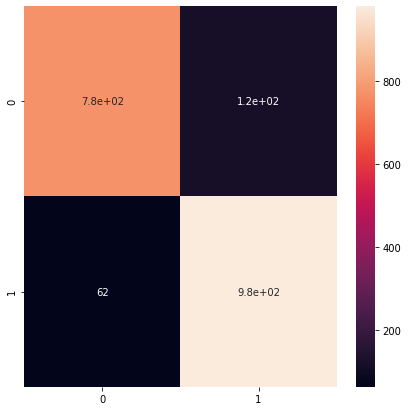

In [0]:
#plotting the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [0]:
#getting the classification report

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       894
           1       0.89      0.94      0.92      1042

    accuracy                           0.91      1936
   macro avg       0.91      0.90      0.91      1936
weighted avg       0.91      0.91      0.91      1936



#Step 5: Segmenation model for classifying and locating the defect in the image:

In [0]:
#creating a custom datagenerator:

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , list_class, list_rle, image_dir, batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.class_type = list_class
    self.rle = list_rle
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the ClassId corresponding to the indexes created above based on batch size
    list_class = [self.class_type[i] for i in indexes]

    #get the rle corresponding to the indexes created above based on batch size
    list_rle = [self.rle[i] for i in indexes]

    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_class, list_rle)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indexes after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indexes based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indexes
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_class, list_rle):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 1 for input and depth is taken as 4 for output becasue of 4 types of defect
    X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 4))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for index, id in enumerate(list_ids):
      #path of the image
      path = os.path.join(self.image_dir, id)

      #reading the image , only channel 0(blue)( we can take any channel or 3 channel as itself, if we are taking 3 channels we need to change X depth to 3)
      img = cv2.imread(path,0)

      #resizing the image and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)

      #standardising the image
      img -= img.mean()
      img /= img.std()

      #creatiing a empty mask for label
      mask = np.empty((self.img_h,self.img_w,4))

      #iterating through the 4 class id to creat mask for each defect of the same image
      for j, class_id in enumerate([1,2,3,4]):

        #getting rle from list, using index used to get the image id
        rle = list_rle[index]

        #create a mask using rle if it belongs to a class_id else create mask with zeros if there no rle belonging to a class_id
        if list_class[i] == class_id:
          class_mask = rle2mask(rle,256,1600)
        else:
          class_mask = np.zeros((256,1600))
        
        #resizing the mask to shape (256,256)
        resized_mask = cv2.resize(class_mask,(self.img_h,self.img_w))

        #adding mask corresponding to each class_id
        mask[...,j] = resized_mask 
      
      #expanding the dimnetion image from (256,256) to (256,256,1)
      X[index,] = np.expand_dims(img, axis = 2)
      y[index,] = mask
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y


In [0]:
#spliting the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_df, test_size=0.2)

In [0]:
#creating separate list for imageId, classId and rle to pass into the generator

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [0]:
#creating image generators

training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


## ResUNet- Model

In [0]:
def resblock(X, f):
  

  #making a copy of input
  X_copy = X

  #main path
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  #Short path

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  #Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [0]:
#function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [0]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

 

## Loss function:
 
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [0]:
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [0]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [0]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="Steel_Defect_Detection/weights_seg.hdf5", verbose=1, save_best_only=True)

In [0]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

Epoch 1/40
354/354 [==============================] - ETA: 0s - loss: 0.4680 - tversky: 0.6008
Epoch 00001: val_loss improved from inf to 0.63382, saving model to Steel_Defect_Detection/weights_seg.hdf5
354/354 [==============================] - 132s 373ms/step - loss: 0.4680 - tversky: 0.6008 - val_loss: 0.6338 - val_tversky: 0.4397
Epoch 2/40
354/354 [==============================] - ETA: 0s - loss: 0.4559 - tversky: 0.6154
Epoch 00002: val_loss did not improve from 0.63382
354/354 [==============================] - 132s 372ms/step - loss: 0.4559 - tversky: 0.6154 - val_loss: 0.6508 - val_tversky: 0.4192
Epoch 3/40
354/354 [==============================] - ETA: 0s - loss: 0.4953 - tversky: 0.5710
Epoch 00003: val_loss improved from 0.63382 to 0.62384, saving model to Steel_Defect_Detection/weights_seg.hdf5
354/354 [==============================] - 133s 377ms/step - loss: 0.4953 - tversky: 0.5710 - val_loss: 0.6238 - val_tversky: 0.4517
Epoch 4/40
354/354 [=========================

In [0]:
model_seg.save('Steel_Defect_Detection/resunet_weight.h5')

In [0]:
#saving the model architecture to json file for future use

model_json = model_seg.to_json()
with open("Steel_Defect_Detection/ResUNet-steel.json","w") as json_file:
  json_file.write(model_json)

## Load the segmentation model:

In [0]:
with open('Steel_Defect_Detection/ResUNet-steel.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('Steel_Defect_Detection/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [0]:
def prediction(test_df):
  '''
  Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
  Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
  is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
  segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
  '''

  #Test directory
  test_dir = "Steel_Defect_Detection/test_images"

  #Creating empty list to store the results
  mask = []
  defect_type = []
  image_id = []

  #iterating through each image in the test data
  for i in test_df.ImageId:

    path = os.path.join(test_dir, i)

    #reading the image
    img = cv2.imread(path)

    #Normalizing the image
    img = img * 1./255.

    #Reshaping the image
    img = cv2.resize(img,(256,256))

    #Converting the image into array
    img = np.array(img, dtype = np.float64)
    
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction on the image
    defect_or_no_defect = model.predict(img)

    #if the image has defect we append the details of the image to the list
    if defect_or_no_defect < 0.01:
      image_id.append(i)
      defect_type.append(0)
      mask.append('1 409600')
      continue

    #reading the image , only channel 0(blue)( we can take any channel or 3 channel as itself, if we are taking 3 channels we need to change X depth to 3)
    img = cv2.imread(path,0)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 1))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256 to 1,256,256,1
    X[0,] = np.expand_dims(img, axis = 2)

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no defect
    if predict.round().astype(int).sum() == 0:
      image_id.append(i)
      defect_type.append(0)
      mask.append('1 409600')
      continue

    #iterating 4 times to get the prediction of 4 different classes
    for j in range(4):
      #since j values through iteration are 0,1,2,3 , we add 1 to j to make it as classIDs corresponding to 1,2,3,4
      class_id = j + 1

      #get the mask values of each class
      mask_value = predict[0,:,:,j].round().astype(int)

      #if the sum of mask values is greater thna 0.5(anything greater than 0), that class has defect
      if mask_value.sum() > 0.5:
        
        #applying mask to image, area with defect will be highlighted in white(255)
        img[mask_value == 1] = 255
        #since our original shape is 256,1600, we reshape to that size
        img = cv2.resize(img,(1600,256))
        #Now, we mask the image such that, areas which are not white(defected areas) to be black(0)
        img[img < 255] = 0
        #we again normalize the values
        img = img * 1./255.
        #get the rle for the create masked image
        rle = mask2rle(img)

        #append the valeues to the respective listes
        image_id.append(i)
        defect_type.append(class_id)
        mask.append(rle)

  return image_id, defect_type, mask
        




In [0]:
#making prediction
image_id, defect_type, mask = prediction(test_df)

In [0]:
#creating a dataframe for the result
df_test= pd.DataFrame({'ImageID': image_id, , 'EncodedPixels': mask, 'ClassId': defect_type,})
df_test.head() 	

,ImageID,ClassId,EncodedPixels
0,0000f269f.jpg,3,5 22 28 6 141 3 261 22 284 6 397 3 517 22 540 ...
1,000ccc2ac.jpg,3,356239 4 356247 2 356343 6 356495 4 356503 2 3...
2,002451917.jpg,3,29704 1 29711 11 29727 1 29737 44 29783 11 297...
3,003c5da97.jpg,3,18639 2 18895 2 19151 2 19407 2 19663 2 19919 ...
4,0042e163f.jpg,3,31244 1 31500 1 31756 1 32012 1 32268 1 32524 ...


In [74]:
df_test.shape

(5506, 3)

In [0]:
#sacing the dataframe to csv file
df_test.to_csv('Steel_Defect_Detection/test_df.csv', encoding='utf-8')

In [1]:
#visualizing the results

for i in range(10):

  #reading the images using opencv and converting to rgb format
  img = cv2.imread(os.path.join(test_dir,df_test.ImageID[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  #getting the mask for the image from rle
  mask = rle2mask(df_test.EncodedPixels[i],img.shape[0],img.shape[1])
  '''
  Applying the mask to the image 'mask==1' and choosing the color '1' -green (since it is in RGB color space R-0, G-1, B-2),
  we have chose 255- white as the inital mask color
  '''

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(train_df.ClassId[i])
  plt.imshow(img)

NameError: ignored